# RESTRICTED BOLTZMANN MACHINES
---

### Initialization

First we have to load the utility file which contains different utility functions that are not connected
in any way to the networks presented in the tutorials, but rather help in
processing the outputs into a more understandable way.

In [1]:
import urllib.request
with urllib.request.urlopen("http://deeplearning.net/tutorial/code/utils.py") as url:
    response = url.read()
target = open('utils.py', 'w')
target.write(response.decode('utf-8'))
target.close()

Now, we load in all the packages that we use to create the net including the TensorFlow package:

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
#!pip install pillow
from PIL import Image
from utils import tile_raster_images
import matplotlib.pyplot as plt
%matplotlib inline

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jupyterlab/conda/envs/python/lib/python3

Here we define the <b>bias</b> of second layer as well. We will denote the bias as “h_bias” for the hidden units. The <b>h_bias</b> is shared among all hidden units

In [3]:
v_bias = tf.placeholder("float", [7])
h_bias = tf.placeholder("float", [2])

We have to define weights among the input layer and hidden layer nodes. In the weight matrix, the number of rows are equal to the input nodes, and the number of columns are equal to the output nodes. Let <b>W</b> be the Tensor of 7x2 (7 - number of visible neurons, 2 - number of hidden neurons) that represents weights between neurons. 

In [4]:
W = tf.constant(np.random.normal(loc=0.0, scale=1.0, size=(7, 2)).astype(np.float32))

Before we go further, let's look at a toy example for one case out of all input. Assume that we have a trained RBM, and a very simple input vector such as [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], lets see what would be the output of forward pass:

In [5]:
sess = tf.Session()
X = tf.constant([[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]])
v_state = X
print ("Input: ", sess.run(v_state))

h_bias = tf.constant([0.1, 0.1])
print ("hb: ", sess.run(h_bias))
print ("w: ", sess.run(W))

# Calculate the probabilities of turning the hidden units on:
h_prob = tf.nn.sigmoid(tf.matmul(v_state, W) + h_bias)  #probabilities of the hidden units
print ("p(h|v): ", sess.run(h_prob))

# Draw samples from the distribution:
h_state = tf.nn.relu(tf.sign(h_prob - tf.random_uniform(tf.shape(h_prob)))) #states
print ("h0 states:", sess.run(h_state))

Input:  [[1. 0. 0. 1. 0. 0. 0.]]
hb:  [0.1 0.1]
w:  [[ 0.5332662  -1.9102893 ]
 [-0.64729184  0.7917447 ]
 [ 0.6837602   1.0867532 ]
 [-0.63897103  1.027463  ]
 [ 0.01046412 -0.5906408 ]
 [ 1.0411279   1.2823282 ]
 [-1.8994617   1.3905194 ]]
p(h|v):  [[0.4985738  0.31371108]]
h0 states: [[0. 0.]]


So, in the second phase (i.e. reconstruction phase), the samples from the hidden layer (i.e. h) play the role of input. That is, <b>h</b> becomes the input in the backward pass. The same weight matrix and visible layer biases are used to go through the sigmoid function. The produced output is a reconstruction which is an approximation of the original input.

In [6]:
vb = tf.constant([0.1, 0.2, 0.1, 0.1, 0.1, 0.2, 0.1])
print ("b: ", sess.run(vb))
v_prob = sess.run(tf.nn.sigmoid(tf.matmul(h_state, tf.transpose(W)) + vb))
print ("p(vi∣h): ", v_prob)
v_state = tf.nn.relu(tf.sign(v_prob - tf.random_uniform(tf.shape(v_prob))))
print ("v probability states: ", sess.run(v_state))

b:  [0.1 0.2 0.1 0.1 0.1 0.2 0.1]
p(vi∣h):  [[0.5249792  0.54983395 0.5249792  0.5249792  0.5249792  0.54983395
  0.5249792 ]]
v probability states:  [[0. 0. 1. 0. 1. 0. 0.]]


RBM learns a probability distribution over the input, and then, after being trained, the RBM can generate new samples from the learned probability distribution. As you know, <b>probability distribution</b>, is a mathematical function that provides the probabilities of occurrence of different possible outcomes in an experiment.

The (conditional) probability distribution over the visible units v is given by

$p(\mathbf{v} \mid \mathbf{h}) = \prod_{i=0}^V p(v_i \mid \mathbf{h}),$


where,

$p(v_i \mid \mathbf{h}) = \sigma\left( a_i + \sum_{j=0}^H w_{ji} h_j \right)$

so, given current state of hidden units and weights, what is the probability of generating [1. 0. 0. 1. 0. 0. 0.] in reconstruction phase, based on the above <b>probability distribution</b> function?

In [7]:
inp = sess.run(X)
print(inp)
print(v_prob[0])
v_probability = 1
for elm, p in zip(inp[0],v_prob[0]) :
    if elm ==1:
        v_probability *= p
    else:
        v_probability *= (1-p)
v_probability

[[1. 0. 0. 1. 0. 0. 0.]]
[0.5249792  0.54983395 0.5249792  0.5249792  0.5249792  0.54983395
 0.5249792 ]


0.0059864253744900215

How similar X and V vectors are? Of course, the reconstructed values most likely will not look anything like the input vector because our network has not trained yet. Our objective is to train the model in such a way that the input vector and reconstructed vector to be same. Therefore, based on how different the input values look to the ones that we just reconstructed, the weights are adjusted. 


<h2>MNIST</h2>


We will be using the MNIST dataset to practice the usage of RBMs. The following cell loads the MNIST dataset.

In [8]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Lets look at the dimension of the images.

In [9]:
trX[1].shape

(784,)

MNIST images have 784 pixels, so the visible layer must have 784 input nodes.  For our case, we'll use 50 nodes in the hidden layer, so i = 50.

In [10]:
vb = tf.placeholder("float", [784])
hb = tf.placeholder("float", [50])

Let <b>W</b> be the Tensor of 784x50 (784 - number of visible neurons, 50 - number of hidden neurons) that represents weights between the neurons. 

In [11]:
W = tf.placeholder("float", [784, 50])

Lets define the visible layer:

In [12]:
v0_state = tf.placeholder("float", [None, 784])

Now, we can define hidden layer:

In [13]:
h0_prob = tf.nn.sigmoid(tf.matmul(v0_state, W) + hb)  #probabilities of the hidden units
h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random_uniform(tf.shape(h0_prob)))) #sample_h_given_X

Now, we define reconstruction part:

In [14]:
v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random_uniform(tf.shape(v1_prob)))) #sample_v_given_h

<h3>What is objective function?</h3>

<b>Goal</b>: Maximize the likelihood of our data being drawn from that distribution

<b>Calculate error:</b>  
In each epoch, we compute the "error" as a sum of the squared difference between step 1 and step n,
e.g the error shows the difference between the data and its reconstruction.

<b>Note:</b> tf.reduce_mean computes the mean of elements across dimensions of a tensor.

In [15]:
err = tf.reduce_mean(tf.square(v0_state - v1_state))

### Train the model

Ok, lets assume that k=1, that is we just get one more step:

In [16]:
h1_prob = tf.nn.sigmoid(tf.matmul(v1_state, W) + hb)
h1_state = tf.nn.relu(tf.sign(h1_prob - tf.random_uniform(tf.shape(h1_prob)))) #sample_h_given_X

In [17]:
alpha = 0.01
W_Delta = tf.matmul(tf.transpose(v0_state), h0_prob) - tf.matmul(tf.transpose(v1_state), h1_prob)
update_w = W + alpha * W_Delta
update_vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
update_hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0)

Let's start a session and initialize the variables:

In [18]:
cur_w = np.zeros([784, 50], np.float32)
cur_vb = np.zeros([784], np.float32)
cur_hb = np.zeros([50], np.float32)
prv_w = np.zeros([784, 50], np.float32)
prv_vb = np.zeros([784], np.float32)
prv_hb = np.zeros([50], np.float32)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

Lets look at the error of the first run:

In [19]:
sess.run(err, feed_dict={v0_state: trX, W: prv_w, vb: prv_vb, hb: prv_hb})

0.48145455

Epoch: 0 reconstruction error: 0.099943
Epoch: 1 reconstruction error: 0.089058
Epoch: 2 reconstruction error: 0.085385
Epoch: 3 reconstruction error: 0.084212
Epoch: 4 reconstruction error: 0.083248


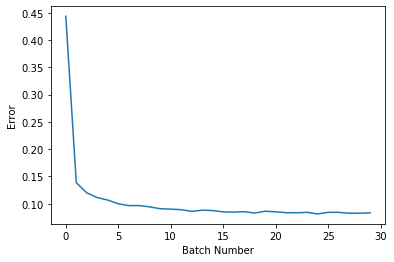

In [20]:
#Parameters
epochs = 5
batchsize = 100
weights = []
errors = []

for epoch in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={ v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={ v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start % 10000 == 0:
            errors.append(sess.run(err, feed_dict={v0_state: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
            weights.append(cur_w)
    print ('Epoch: %d' % epoch,'reconstruction error: %f' % errors[-1])
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

What is the final weight after training?

In [21]:
uw = weights[-1].T
print (uw) # a weight matrix of shape (50,784)

[[-0.953128   -1.0605879  -0.99059737 ... -0.9327604  -1.0077841
  -0.96909   ]
 [-1.9837399  -1.8666668  -1.9596486  ... -1.7513443  -1.8298361
  -1.8580841 ]
 [-0.62390214 -0.65390897 -0.5916143  ... -0.6201386  -0.6691202
  -0.5844657 ]
 ...
 [-0.37899655 -0.33749086 -0.3439962  ... -0.3196499  -0.34715736
  -0.32027036]
 [-2.7894008  -2.9224937  -2.7512028  ... -2.8350337  -2.900528
  -2.853664  ]
 [-1.2511277  -1.1305019  -1.1654112  ... -1.0987622  -1.186039
  -1.1033281 ]]


<a id="ref5"></a>
<h3>Learned features</h3> 

We can take each hidden unit and visualize the connections between that hidden unit and each element in the input vector. In our case, we have 50 hidden units. Lets visualize those.

Let's plot the current weights:
<b>tile_raster_images</b> helps in generating an easy to grasp image from a set of samples or weights. It transform the <b>uw</b> (with one flattened image per row of size 784), into an array (of size $25\times20$) in which images are reshaped and laid out like tiles on a floor.

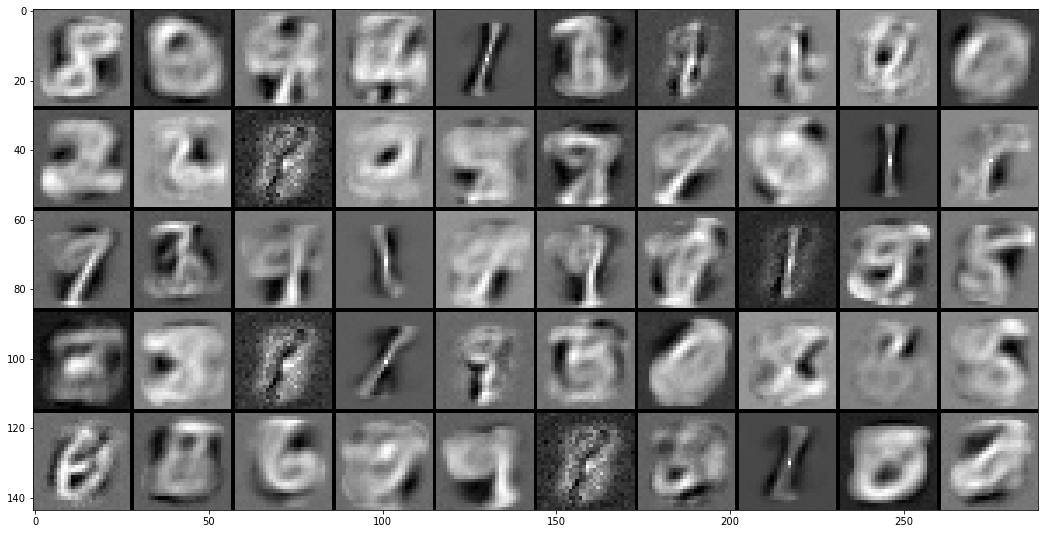

In [22]:
tile_raster_images(X=cur_w.T, img_shape=(28, 28), tile_shape=(5, 10), tile_spacing=(1, 1))
image = Image.fromarray(tile_raster_images(X=cur_w.T, img_shape=(28, 28) ,tile_shape=(5, 10), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

Each tile in the above visualization corresponds to a vector of connections between a hidden unit and visible layer's units. 

Let's look at one of the learned weights corresponding to one of hidden units for example. In this particular square, the gray color represents weight = 0, and the whiter it is, the more positive the weights are (closer to 1). Conversely, the darker pixels are, the more negative the weights. The positive pixels will increase the probability of activation in hidden units (after multiplying by input/visible pixels), and negative pixels will decrease the probability of a unit hidden to be 1 (activated). So, why is this important?  So we can see that this specific square (hidden unit) can detect a feature (e.g. a "/" shape) and if it exists in the input.

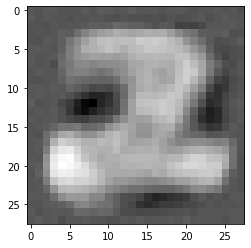

In [23]:
image = Image.fromarray(tile_raster_images(X =cur_w.T[10:11], img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

Let's look at the reconstruction of an image now. Imagine that we have a destructed image of figure 3. Lets see if our trained network can fix it:

First we plot the image:

--2020-07-09 07:15:09--  https://ibm.box.com/shared/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
Resolving ibm.box.com (ibm.box.com)... 107.152.29.197
Connecting to ibm.box.com (ibm.box.com)|107.152.29.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg [following]
--2020-07-09 07:15:10--  https://ibm.box.com/public/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg [following]
--2020-07-09 07:15:10--  https://ibm.ent.box.com/public/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
Resolving ibm.ent.box.com (ibm.ent.box.com)... 107.152.27.211
Connecting to ibm.ent.box.com (ibm.ent.box.com)|107.152.27.211|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b

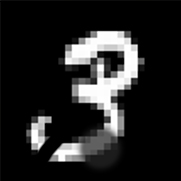

In [24]:
!wget -O destructed3.jpg  https://ibm.box.com/shared/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
img = Image.open('destructed3.jpg')
img

Now let's pass this image through the net:

In [25]:
# convert the image to a 1d numpy array
sample_case = np.array(img.convert('I').resize((28,28))).ravel().reshape((1, -1))/255.0

Feed the sample case into the network and reconstruct the output:

In [26]:
hh0_p = tf.nn.sigmoid(tf.matmul(v0_state, W) + hb)
#hh0_s = tf.nn.relu(tf.sign(hh0_p - tf.random_uniform(tf.shape(hh0_p)))) 
hh0_s = tf.round(hh0_p)
hh0_p_val,hh0_s_val  = sess.run((hh0_p, hh0_s), feed_dict={ v0_state: sample_case, W: prv_w, hb: prv_hb})
print("Probability nodes in hidden layer:" ,hh0_p_val)
print("activated nodes in hidden layer:" ,hh0_s_val)

# reconstruct
vv1_p = tf.nn.sigmoid(tf.matmul(hh0_s_val, tf.transpose(W)) + vb)
rec_prob = sess.run(vv1_p, feed_dict={ hh0_s: hh0_s_val, W: prv_w, vb: prv_vb})

Probability nodes in hidden layer: [[9.9892718e-01 8.1086311e-09 3.7734915e-27 2.6990129e-14 8.2951122e-28
  3.8330681e-16 8.8073670e-05 2.0802519e-18 3.7166988e-11 9.9974662e-01
  9.9999893e-01 1.4928387e-32 3.1941692e-08 7.4635659e-10 1.4205844e-04
  3.4380002e-15 3.7135236e-30 2.8047074e-12 7.0822817e-37 3.2935455e-27
  4.4888272e-36 1.2075593e-25 5.0595038e-24 5.1491979e-35 1.4505398e-17
  5.1114156e-32 1.6398930e-07 1.6077958e-06 9.9998212e-01 9.0040693e-32
  1.0000000e+00 9.9999690e-01 6.9221625e-07 0.0000000e+00 8.5345040e-05
  5.0425881e-01 4.3955403e-08 2.6598283e-12 6.4313590e-17 1.5330162e-25
  4.3724039e-01 5.2249816e-06 0.0000000e+00 8.2016410e-03 0.0000000e+00
  3.8476525e-08 9.3922824e-01 2.5971815e-28 9.9999988e-01 3.8474019e-35]]
activated nodes in hidden layer: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  1. 0.]]


Here we plot the reconstructed image:

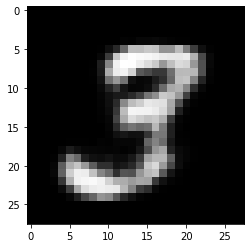

In [27]:
img = Image.fromarray(tile_raster_images(X=rec_prob, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray') 

## Thanks for reading :)
Created by [Saeed Aghabozorgi](https://www.linkedin.com/in/saeedaghabozorgi/) and modified by [Tarun Kamboj](https://www.linkedin.com/in/kambojtarun/).